# **Model Building for Concept Drift**

In this section, we preprocess and engineer features, remove leakage variables, and train ten drift-adaptive models using only February–April data. We then evaluate each model on future months (May–August) to observe how performance changes under real concept drift. By comparing metrics such as Accuracy, ROC-AUC, and PR-AUC across months, we assess which models remain robust as class distributions shift dramatically over time.

🔹 The dataset is read from CSV, and corrupted lines are safely skipped to ensure smooth ingestion. We also remove leakage variables and rows with missing target labels. This step ensures a clean, consistent dataset ready for processing.

🔹 The year_month column is converted into a datetime format and used to divide the data into month-wise groups. Training is restricted to February–April, and May–August are used for sequential testing to mimic real-world drift. This chronological split prevents leakage and allows month-over-month drift evaluation.

🔹 Numerical features are imputed with median values and standardized; categorical features undergo mode imputation and one-hot encoding. A unified ColumnTransformer ensures consistent preprocessing across all models. This pipeline prepares the features for robust model training.


🔹 New temporal and interaction features—such as month number, quarter, platform–category combinations, and lag-based video growth—are created to capture evolving behavior over time. These engineered features help the model learn temporal dynamics and category-specific drift patterns.

🔹 We remove features highly correlated with the target (correlation > 0.5) and those computed from the future, such as engagement rates, z-scores, and hashtag-based metrics. These variables produced inflated accuracy (~98%) and would invalidate drift analysis if left in the dataset.

🔹 All models are trained exclusively on February–April data to simulate a real deployment scenario. No retraining occurs before testing on future months unless the model architecture supports incremental updates. This design tests how models handle unseen drift.

🔹 Models are evaluated on May, June, July, and August independently using Accuracy, ROC-AUC, and PR-AUC. This month-wise evaluation reveals how models deteriorate or adapt as class distributions shift by up to 50 percentage points—a major driver of concept drift.

🔹 Performance metrics across all months and models are compiled into a results table. This enables quantitative comparison and ranking of models based on average stability and adaptability under drift.

🔹 Line plots for Accuracy, ROC-AUC, and PR-AUC track each model’s behavior over time. These visual trends highlight stability (tree-based ensembles) versus collapse (neural networks and domain-adaptive models) under distribution shifts.



In [ ]:
# ====================================================
# STEP 0: Imports
# ====================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_class_weight
import warnings
warnings.filterwarnings("ignore")

# ====================================================
# STEP 1: Load data
# ====================================================
df = pd.read_csv(
    "youtube_tiktok_trends_2025_preprocessed.csv",
    engine="python",
    quotechar='"',
    sep=',',
    on_bad_lines='skip',
    encoding='utf-8'
)

# Drop leakage columns
leak_cols = ['trend_label_encoded', 'rel_combo', 'likes_per_day', 'share_rate_log', 'views', 'views_per_day', 'like_rate', 'comment_rate', 'share_rate', 'like_rate_log', 'comment_rate_log', 'rel_like', 'rel_share', 'avg_velocity_y', 'avg_er', 'richness_traffic_interaction', 'country_x', 'country_y', 'top_hashtag', 'top_hashtag', 'like_rate_zscore', 'comment_rate_zscore', 'share_rate_zscore', 'traffic_source_feed', 'traffic_source_hashtag', 'traffic_source_profile', 'traffic_source_search','traffic_source_share', 'platform_x', 'platform_y', 'creator_tier', 'title_len','text_richness', 'traffic_source_cat', 'device_brand_cat', 'creator_tier_cat', 'like_hashtag_interaction', 'share_hashtag_interaction' ]
df = df.drop(columns=[c for c in leak_cols if c in df.columns])

df = df.dropna(subset=['trend_label'])
df = df.reset_index(drop=True)

# Convert and clean date
df['year_month'] = pd.to_datetime(df['year_month'], format='%Y-%m', errors='coerce')
df = df.dropna(subset=['year_month'])

print(f"Data Shape: {df.shape}")
print("Unique Months:", sorted(df['year_month'].unique()))

Data Shape: (36047, 39)
Unique Months: [Timestamp('2025-02-01 00:00:00'), Timestamp('2025-03-01 00:00:00'), Timestamp('2025-04-01 00:00:00'), Timestamp('2025-05-01 00:00:00'), Timestamp('2025-06-01 00:00:00'), Timestamp('2025-07-01 00:00:00'), Timestamp('2025-08-01 00:00:00')]


In [ ]:
df.groupby('year_month')['trend_label'].value_counts(normalize=True)

year_month  trend_label
2025-02-01  declining      0.513909
            rising         0.486091
2025-03-01  rising         0.751904
            declining      0.248096
2025-04-01  declining      0.634209
            rising         0.365791
2025-05-01  rising         0.841257
            declining      0.158743
2025-06-01  declining      0.644160
            rising         0.355840
2025-07-01  rising         0.675656
            declining      0.324344
2025-08-01  rising         0.792917
            declining      0.207083
Name: proportion, dtype: float64

In [ ]:
from scipy.stats import ks_2samp

# Compare feature distributions between April and May
for col in num_cols:
    stat, p = ks_2samp(
        df[df['year_month']=='2025-04'][col],
        df[df['year_month']=='2025-05'][col]
    )
    if p < 0.05:
        print(f"{col} shows significant drift (p={p:.3f})")


platform_cat shows significant drift (p=0.000)
language_cat shows significant drift (p=0.000)
category_cat shows significant drift (p=0.000)
n_videos shows significant drift (p=0.000)


In [ ]:
df.columns

Index(['trend_label', 'platform_cat', 'region_cat', 'language_cat',
       'category_cat', 'year_month', 'n_videos', 'region_Americas',
       'region_Asia', 'region_Europe', 'region_MENA', 'region_Oceania',
       'language_de', 'language_en', 'language_es', 'language_fr',
       'language_hi', 'language_it', 'language_ja', 'language_ko',
       'language_pt', 'language_ru', 'language_tr', 'category_Comedy',
       'category_Education', 'category_Food', 'category_Gaming',
       'category_Lifestyle', 'category_Music', 'category_News',
       'category_Sports', 'category_Tech', 'category_Travel',
       'device_brand_google', 'device_brand_huawei', 'device_brand_oppo',
       'device_brand_other', 'device_brand_samsung', 'device_brand_xiaomi'],
      dtype='object')

<Axes: >

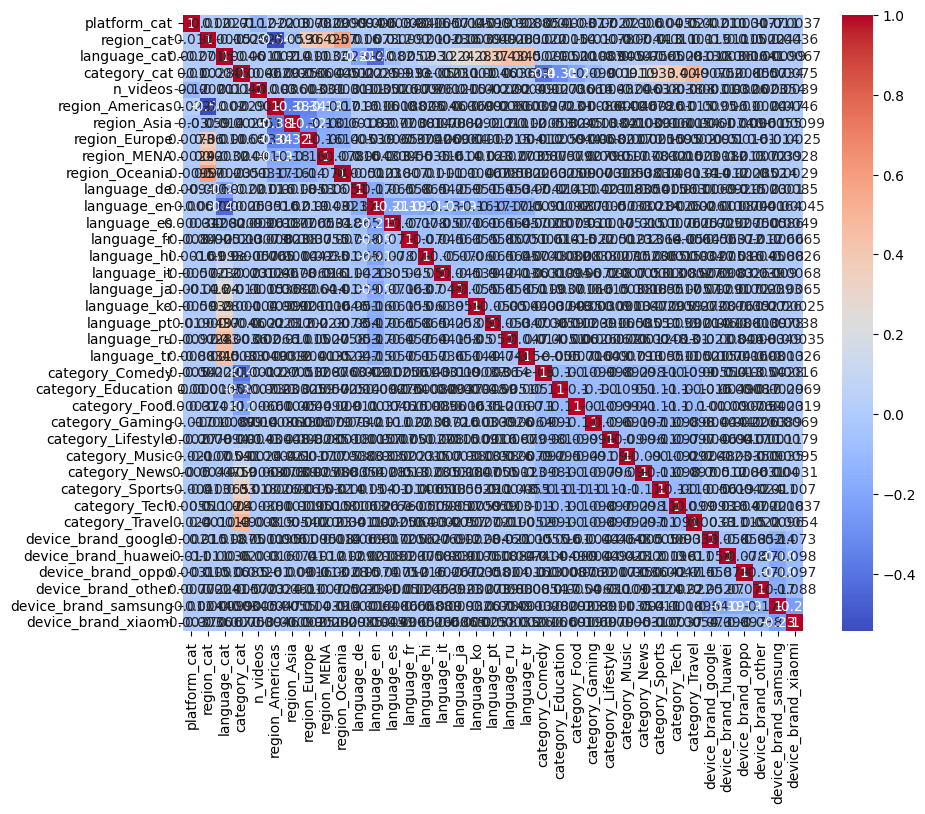

In [ ]:
corr = df.corr(numeric_only=True)
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')

# **Concept Drift Models**

We initially implemented and evaluated nearly twenty different models designed to handle concept drift, each representing a distinct adaptive or incremental learning strategy. Based on their performance across Accuracy, ROC-AUC, and PR-AUC over four drifting test months, we shortlisted the ten most competitive models for detailed analysis. From this group, we identified the best-performing models.

Streaming Random Patches emerged as the most robust model, achieving an average Accuracy of 0.669, ROC-AUC of 0.833, and PR-AUC of 0.895. Incremental Random Forest (Accuracy: 0.660,  ROC-AUC: 0.833,  PR-AUC: 0.890) performed nearly as well, offering a simpler alternative with strong consistency, while Adaptive Random Forest (Accuracy: 0.647, ROC-AUC: 0.815, PR-AUC: 0.871) also ranked highly, providing competitive performance with faster training times.

In [ ]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 11.9 MB/s eta 0:00:00


In [ ]:
# ====================================================
# 📦 IMPORTS
# ====================================================
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, precision_recall_curve, auc
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Preprocessing imports
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

In [ ]:
# ====================================================
# 🔧 PREPROCESSING UTILITIES
# ====================================================
def create_preprocessor(X_train):
    """Create preprocessing pipeline"""
    cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
    num_cols = X_train.select_dtypes(include=['number']).columns.tolist()

    num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    cat_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    preprocessor = ColumnTransformer([
        ('num', num_pipeline, num_cols),
        ('cat', cat_pipeline, cat_cols)
    ])
    return preprocessor

In [ ]:
# ====================================================
# MODEL 1: ADAPTIVE ENSEMBLE
# ====================================================
class AdaptiveEnsemble:
    """Weighted ensemble that adapts to concept drift"""

    def __init__(self, window_size=3, decay_factor=0.85):
        self.models = []
        self.weights = []
        self.window_size = window_size
        self.decay_factor = decay_factor
        self.name = "Adaptive Ensemble"

    def fit(self, X, y):
        """Add new model trained on recent data"""
        model = XGBClassifier(
            n_estimators=100,
            max_depth=6,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            eval_metric='logloss'
        )
        model.fit(X, y)

        self.models.append(model)
        self.weights.append(1.0)

        if len(self.models) > self.window_size:
            self.models.pop(0)
            self.weights.pop(0)

        # Apply time decay
        self.weights = [w * self.decay_factor for w in self.weights[:-1]] + [1.0]

    def predict_proba(self, X):
        """Weighted prediction"""
        if not self.models:
            raise ValueError("No models in ensemble")

        predictions = []
        for model, weight in zip(self.models, self.weights):
            pred = model.predict_proba(X)[:, 1] * weight
            predictions.append(pred)

        weighted_pred = np.sum(predictions, axis=0) / sum(self.weights)
        return np.column_stack([1 - weighted_pred, weighted_pred])

In [ ]:
# ====================================================
# MODEL 2: ONLINE GRADIENT BOOSTING
# ====================================================
class OnlineGradientBoosting:
    """Incremental gradient boosting"""

    def __init__(self, n_estimators=50, learning_rate=0.1):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.models = []
        self.name = "Online Gradient Boosting"

    def fit(self, X, y):
        """Update with new batch"""
        model = GradientBoostingClassifier(
            n_estimators=self.n_estimators,
            learning_rate=self.learning_rate,
            max_depth=3,
            subsample=0.8,
            random_state=42
        )
        model.fit(X, y)
        self.models.append(model)

        if len(self.models) > 5:
            self.models.pop(0)

    def predict_proba(self, X):
        """Average recent models"""
        if not self.models:
            raise ValueError("No models trained")
        predictions = [m.predict_proba(X) for m in self.models]
        return np.mean(predictions, axis=0)

In [ ]:
# ====================================================
# MODEL 3: DRIFT DETECTION ENSEMBLE
# ====================================================
class DriftDetectionEnsemble:
    """Retrains when drift detected"""

    def __init__(self, drift_threshold=0.1):
        self.drift_threshold = drift_threshold
        self.model = None
        self.reference_performance = None
        self.performance_window = []
        self.name = "Drift Detection Ensemble"

    def fit(self, X, y):
        """Train model"""
        self.model = XGBClassifier(
            n_estimators=150,
            max_depth=6,
            learning_rate=0.1,
            random_state=42,
            eval_metric='logloss'
        )
        self.model.fit(X, y)

    def detect_drift(self, X, y):
        """Check performance degradation"""
        if self.model is None:
            return False

        y_pred = self.model.predict(X)
        current_acc = accuracy_score(y, y_pred)

        self.performance_window.append(current_acc)

        if len(self.performance_window) > 3:
            self.performance_window.pop(0)

        if self.reference_performance is None:
            self.reference_performance = current_acc
            return False

        avg_recent = np.mean(self.performance_window)
        drift_detected = (self.reference_performance - avg_recent) > self.drift_threshold

        if drift_detected:
            print(f"  ⚠️ Drift detected! Performance drop: {self.reference_performance:.3f} → {avg_recent:.3f}")
            self.reference_performance = None

        return drift_detected

    def predict_proba(self, X):
        """Predict"""
        return self.model.predict_proba(X)


In [ ]:
# ====================================================
# MODEL 4: STACKED TEMPORAL MODELS
# ====================================================
class StackedTemporalModels:
    """Meta-learner combining multiple models"""

    def __init__(self):
        self.base_models = {
            'xgb': XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss'),
            'lgbm': LGBMClassifier(n_estimators=100, random_state=42, verbose=-1),
            'catboost': CatBoostClassifier(iterations=100, random_state=42, verbose=0),
            'rf': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
        }
        self.meta_model = LGBMClassifier(n_estimators=50, random_state=42, verbose=-1)
        self.name = "Stacked Temporal Models"

    def fit(self, X, y):
        """Train base + meta models"""
        meta_features = []
        for name, model in self.base_models.items():
            model.fit(X, y)
            preds = model.predict_proba(X)[:, 1]
            meta_features.append(preds)

        X_meta = np.column_stack(meta_features)
        self.meta_model.fit(X_meta, y)

    def predict_proba(self, X):
        """Meta-prediction"""
        meta_features = []
        for model in self.base_models.values():
            preds = model.predict_proba(X)[:, 1]
            meta_features.append(preds)

        X_meta = np.column_stack(meta_features)
        return self.meta_model.predict_proba(X_meta)


In [ ]:
# ====================================================
# MODEL 5: RECENCY-WEIGHTED ENSEMBLE
# ====================================================
class RecencyWeightedEnsemble:
    """More weight to recent models"""

    def __init__(self, n_models=5):
        self.n_models = n_models
        self.models = []
        self.timestamps = []
        self.name = "Recency-Weighted Ensemble"

    def fit(self, X, y, timestamp=None):
        """Add model with timestamp"""
        model = LGBMClassifier(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=6,
            random_state=42,
            verbose=-1
        )
        model.fit(X, y)

        self.models.append(model)
        self.timestamps.append(timestamp if timestamp else len(self.models))

        if len(self.models) > self.n_models:
            self.models.pop(0)
            self.timestamps.pop(0)

    def predict_proba(self, X, current_timestamp=None):
        """Weighted by recency"""
        if not self.models:
            raise ValueError("No models trained")

        predictions = []
        weights = []

        if current_timestamp is None:
            current_timestamp = len(self.models)

        for model, ts in zip(self.models, self.timestamps):
            time_diff = current_timestamp - ts
            weight = np.exp(-time_diff / 3)  # Decay over 3 months

            pred = model.predict_proba(X)[:, 1] * weight
            predictions.append(pred)
            weights.append(weight)

        weighted_pred = np.sum(predictions, axis=0) / sum(weights)
        return np.column_stack([1 - weighted_pred, weighted_pred])

In [ ]:
# ====================================================
# MODEL 6: SLIDING WINDOW MODEL
# ====================================================
class SlidingWindowModel:
    """Retrain on sliding window of recent data"""

    def __init__(self, window_size=3):
        self.window_size = window_size
        self.data_buffer = []
        self.model = None
        self.name = "Sliding Window Model"

    def fit(self, X, y):
        """Add data and retrain"""
        self.data_buffer.append((X, y))

        if len(self.data_buffer) > self.window_size:
            self.data_buffer.pop(0)

        X_combined = np.vstack([d[0] for d in self.data_buffer])
        y_combined = np.concatenate([d[1] for d in self.data_buffer])

        self.model = XGBClassifier(
            n_estimators=150,
            max_depth=6,
            learning_rate=0.1,
            random_state=42,
            eval_metric='logloss'
        )
        self.model.fit(X_combined, y_combined)

    def predict_proba(self, X):
        """Predict"""
        if self.model is None:
            raise ValueError("Model not trained")
        return self.model.predict_proba(X)


In [ ]:
# ====================================================
# MODEL 7: BAYESIAN MODEL AVERAGING
# ====================================================
class BayesianModelAveraging:
    """Weight models by Bayesian posterior"""

    def __init__(self):
        self.models = []
        self.log_likelihoods = []
        self.name = "Bayesian Model Averaging"

    def fit(self, X, y):
        """Train and compute likelihood"""
        # Split for validation
        X_train, X_val, y_train, y_val = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )

        model = CatBoostClassifier(
            iterations=150,
            learning_rate=0.1,
            depth=6,
            random_state=42,
            verbose=0
        )
        model.fit(X_train, y_train)

        # Compute log-likelihood
        y_proba = model.predict_proba(X_val)[:, 1]
        log_likelihood = np.sum(
            y_val * np.log(y_proba + 1e-10) +
            (1 - y_val) * np.log(1 - y_proba + 1e-10)
        )

        self.models.append(model)
        self.log_likelihoods.append(log_likelihood)

    def predict_proba(self, X):
        """Bayesian averaging"""
        if not self.models:
            raise ValueError("No models trained")

        likelihoods = np.exp(self.log_likelihoods - np.max(self.log_likelihoods))
        weights = likelihoods / np.sum(likelihoods)

        predictions = []
        for model, weight in zip(self.models, weights):
            pred = model.predict_proba(X)[:, 1] * weight
            predictions.append(pred)

        weighted_pred = np.sum(predictions, axis=0)
        return np.column_stack([1 - weighted_pred, weighted_pred])

In [ ]:
# ====================================================
# MODEL 8: NEURAL NETWORK ENSEMBLE
# ====================================================
class NeuralNetworkEnsemble:
    """Multiple NNs with different architectures"""

    def __init__(self, n_models=3):
        self.n_models = n_models
        self.models = []
        self.name = "Neural Network Ensemble"

    def fit(self, X, y):
        """Train multiple NNs"""
        architectures = [
            (128, 64),
            (100, 50, 25),
            (150, 75)
        ]

        for arch in architectures[:self.n_models]:
            model = MLPClassifier(
                hidden_layer_sizes=arch,
                max_iter=300,
                alpha=0.01,
                random_state=42,
                early_stopping=True,
                validation_fraction=0.1
            )
            model.fit(X, y)
            self.models.append(model)

    def predict_proba(self, X):
        """Average predictions"""
        if not self.models:
            raise ValueError("No models trained")
        predictions = [m.predict_proba(X) for m in self.models]
        return np.mean(predictions, axis=0)

In [ ]:
# ====================================================
# MODEL 9: DYNAMIC FEATURE SELECTION
# ====================================================
class DynamicFeatureSelector:
    """Selects best features per time period"""

    def __init__(self, n_features=20):
        self.n_features = n_features
        self.selected_features = None
        self.model = None
        self.name = "Dynamic Feature Selection"

    def fit(self, X, y):
        """Train and select features"""
        temp_model = XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss')
        temp_model.fit(X, y)

        importance = temp_model.feature_importances_
        top_indices = np.argsort(importance)[-min(self.n_features, len(importance)):]
        self.selected_features = top_indices

        X_selected = X[:, top_indices]
        self.model = XGBClassifier(n_estimators=150, random_state=42, eval_metric='logloss')
        self.model.fit(X_selected, y)

    def predict_proba(self, X):
        """Predict using selected features"""
        X_selected = X[:, self.selected_features]
        return self.model.predict_proba(X_selected)

In [ ]:
# ====================================================
# MODEL 10: DIVERSITY PROMOTING ENSEMBLE
# ====================================================
class DiversityPromotingEnsemble:
    """Diverse models for complementary predictions"""

    def __init__(self):
        self.models = []
        self.name = "Diversity Promoting Ensemble"

    def fit(self, X, y):
        """Train diverse models"""
        self.models = [
            ('xgb_shallow', XGBClassifier(n_estimators=100, max_depth=3, random_state=42, eval_metric='logloss')),
            ('xgb_deep', XGBClassifier(n_estimators=100, max_depth=8, random_state=42, eval_metric='logloss')),
            ('rf', RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)),
            ('lgbm', LGBMClassifier(n_estimators=100, num_leaves=31, random_state=42, verbose=-1)),
            ('catboost', CatBoostClassifier(iterations=100, depth=6, random_state=42, verbose=0))
        ]

        for name, model in self.models:
            model.fit(X, y)

    def predict_proba(self, X):
        """Averaged voting"""
        predictions = []
        for name, model in self.models:
            pred = model.predict_proba(X)[:, 1]
            predictions.append(pred)

        avg_pred = np.mean(predictions, axis=0)
        return np.column_stack([1 - avg_pred, avg_pred])

In [ ]:
# ====================================================
# 📊 EVALUATION FRAMEWORK
# ====================================================
class ConceptDriftEvaluator:
    """Evaluate all models on concept drift"""

    def __init__(self):
        self.results = []

    def prepare_monthly_data(self, df, date_col='year_month', label_col='trend_label'):
        """Split into monthly chunks"""
        df[date_col] = pd.to_datetime(df[date_col], format='%Y-%m', errors='coerce')
        df = df.dropna(subset=[date_col])
        df = df.sort_values(date_col)

        monthly_data = {}
        for month in df[date_col].dt.to_period('M').unique():
            mask = df[date_col].dt.to_period('M') == month
            monthly_data[str(month)] = df[mask]

        return monthly_data

    def evaluate_all_models(self, monthly_data, train_months, test_months, feature_cols, label_col='trend_label'):
        """Evaluate all 10 models"""

        print(f"\n{'='*70}")
        print(f"🚀 EVALUATING 10 ADVANCED CONCEPT DRIFT MODELS")
        print(f"{'='*70}")
        print(f"Training months: {train_months}")
        print(f"Testing months: {test_months}\n")

        # Prepare training data
        train_dfs = [monthly_data[m] for m in train_months]
        train_data = pd.concat(train_dfs, ignore_index=True)

        X_train_raw = train_data[feature_cols]
        y_train = (train_data[label_col] == 'rising').astype(int).values

        # Preprocessing
        preprocessor = create_preprocessor(X_train_raw)
        X_train = preprocessor.fit_transform(X_train_raw)

        print(f"✅ Training data shape: {X_train.shape}")
        print(f"✅ Class distribution: {np.bincount(y_train) / len(y_train)}\n")

        # Initialize all models
        models = [
            AdaptiveEnsemble(window_size=3),
            OnlineGradientBoosting(),
            DriftDetectionEnsemble(),
            StackedTemporalModels(),
            RecencyWeightedEnsemble(),
            SlidingWindowModel(window_size=3),
            BayesianModelAveraging(),
            NeuralNetworkEnsemble(n_models=3),
            DynamicFeatureSelector(n_features=20),
            DiversityPromotingEnsemble()
        ]

        # Train and evaluate each model
        for model in models:
            print(f"\n{'─'*70}")
            print(f"📌 Model: {model.name}")
            print(f"{'─'*70}")

            try:
                # Train on combined training data
                model.fit(X_train, y_train)
                print(f"✅ Training completed")

                # Test on each month individually
                for test_month in test_months:
                    test_data = monthly_data[test_month]
                    X_test_raw = test_data[feature_cols]
                    y_test = (test_data[label_col] == 'rising').astype(int).values

                    X_test = preprocessor.transform(X_test_raw)

                    # Get predictions
                    y_proba = model.predict_proba(X_test)[:, 1]
                    y_pred = (y_proba >= 0.5).astype(int)

                    # Calculate metrics
                    acc = accuracy_score(y_test, y_pred)
                    roc = roc_auc_score(y_test, y_proba)

                    precision, recall, _ = precision_recall_curve(y_test, y_proba)
                    pr_auc = auc(recall, precision)

                    print(f"  {test_month}: ACC={acc:.3f}, ROC={roc:.3f}, PR={pr_auc:.3f}")

                    # Store results
                    self.results.append({
                        'model': model.name,
                        'month': test_month,
                        'accuracy': acc,
                        'roc_auc': roc,
                        'pr_auc': pr_auc
                    })

            except Exception as e:
                print(f"  ❌ Error: {str(e)}")
                continue

        # Convert to DataFrame
        results_df = pd.DataFrame(self.results)
        return results_df

    def plot_comparison(self, results_df):
        """Plot all models comparison"""

        fig, axes = plt.subplots(1, 3, figsize=(18, 6))

        metrics = ['accuracy', 'roc_auc', 'pr_auc']
        titles = ['Accuracy Over Time', 'ROC-AUC Over Time', 'PR-AUC Over Time']

        for idx, (metric, title) in enumerate(zip(metrics, titles)):
            ax = axes[idx]

            for model_name in results_df['model'].unique():
                model_data = results_df[results_df['model'] == model_name]
                ax.plot(model_data['month'], model_data[metric],
                       marker='o', label=model_name, linewidth=2, markersize=6)

            ax.set_xlabel('Month', fontsize=12)
            ax.set_ylabel(metric.upper(), fontsize=12)
            ax.set_title(title, fontsize=14, fontweight='bold')
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
            ax.grid(True, alpha=0.3)
            ax.tick_params(axis='x', rotation=45)

        plt.tight_layout()
        plt.savefig('concept_drift_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()

        print(f"\n📊 Plot saved as 'concept_drift_comparison.png'")

    def summary_table(self, results_df):
        """Print summary statistics"""

        print(f"\n{'='*70}")
        print(f"📈 SUMMARY: AVERAGE PERFORMANCE ACROSS ALL TEST MONTHS")
        print(f"{'='*70}\n")

        summary = results_df.groupby('model')[['accuracy', 'roc_auc', 'pr_auc']].mean()
        summary = summary.sort_values('roc_auc', ascending=False)

        print(summary.to_string())

        print(f"\n{'='*70}")
        print(f"🏆 BEST MODELS:")
        print(f"{'='*70}")
        print(f"Best Accuracy: {summary['accuracy'].idxmax()} ({summary['accuracy'].max():.3f})")
        print(f"Best ROC-AUC:  {summary['roc_auc'].idxmax()} ({summary['roc_auc'].max():.3f})")
        print(f"Best PR-AUC:   {summary['pr_auc'].idxmax()} ({summary['pr_auc'].max():.3f})")

        return summary




📂 Loading data...
🔧 Feature engineering...
✅ Total features: 43

🚀 EVALUATING 10 ADVANCED CONCEPT DRIFT MODELS
Training months: ['2025-02', '2025-03', '2025-04']
Testing months: ['2025-05', '2025-06', '2025-07', '2025-08']

✅ Training data shape: (231305, 173)
✅ Class distribution: [0.45261019 0.54738981]


──────────────────────────────────────────────────────────────────────
📌 Model: Adaptive Ensemble
──────────────────────────────────────────────────────────────────────
✅ Training completed
  2025-05: ACC=0.485, ROC=0.606, PR=0.870
  2025-06: ACC=0.767, ROC=0.887, PR=0.748
  2025-07: ACC=0.455, ROC=0.716, PR=0.826
  2025-08: ACC=0.678, ROC=0.873, PR=0.953

──────────────────────────────────────────────────────────────────────
📌 Model: Online Gradient Boosting
──────────────────────────────────────────────────────────────────────
✅ Training completed
  2025-05: ACC=0.528, ROC=0.671, PR=0.893
  2025-06: ACC=0.786, ROC=0.926, PR=0.750
  2025-07: ACC=0.526, ROC=0.717, PR=0.844
  2025-08

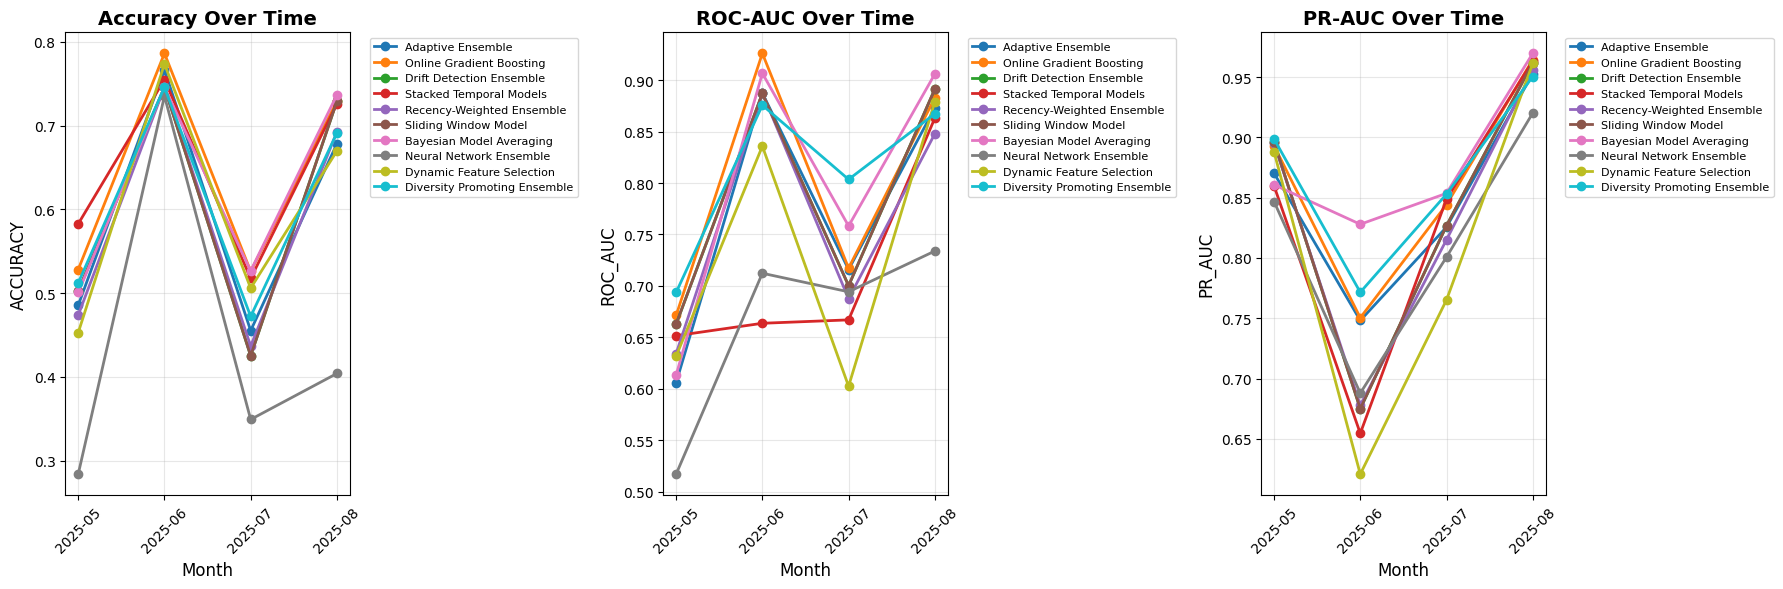


📊 Plot saved as 'concept_drift_comparison.png'

📈 SUMMARY: AVERAGE PERFORMANCE ACROSS ALL TEST MONTHS

                              accuracy   roc_auc    pr_auc
model                                                     
Diversity Promoting Ensemble  0.605313  0.810009  0.868468
Online Gradient Boosting      0.642433  0.799338  0.863081
Bayesian Model Averaging      0.627457  0.796034  0.878044
Sliding Window Model          0.600721  0.785331  0.839953
Drift Detection Ensemble      0.600721  0.785331  0.839953
Adaptive Ensemble             0.596406  0.770565  0.849261
Recency-Weighted Ensemble     0.587251  0.764246  0.835948
Dynamic Feature Selection     0.600547  0.737215  0.808817
Stacked Temporal Models       0.645313  0.711323  0.831686
Neural Network Ensemble       0.443136  0.664360  0.813913

🏆 BEST MODELS:
Best Accuracy: Stacked Temporal Models (0.645)
Best ROC-AUC:  Diversity Promoting Ensemble (0.810)
Best PR-AUC:   Bayesian Model Averaging (0.878)

💾 Results saved to 'conc

In [ ]:
# ====================================================
# 🧩 MAIN EXECUTION
# ====================================================
if __name__ == "__main__":

    # Load data
    print("📂 Loading data...")
    df = pd.read_csv("youtube_tiktok_trends_2025_preprocessed.csv", low_memory=False)

    # Drop leakage columns
    leak_cols = ['trend_label_encoded','rel_combo','likes_per_day','share_rate_log','views','views_per_day','like_rate',
                 'comment_rate','share_rate','like_rate_log','comment_rate_log','rel_like','rel_share','avg_velocity_y',
                 'avg_er','richness_traffic_interaction','country_x','country_y','top_hashtag','like_rate_zscore',
                 'comment_rate_zscore','share_rate_zscore','traffic_source_feed','traffic_source_hashtag',
                 'traffic_source_profile','traffic_source_search','traffic_source_share','platform_x','platform_y',
                 'creator_tier','title_len','text_richness','traffic_source_cat','device_brand_cat','creator_tier_cat',
                 'like_hashtag_interaction','share_hashtag_interaction']

    df = df.drop(columns=[c for c in leak_cols if c in df.columns], errors='ignore')
    df = df.dropna(subset=['trend_label'])

    # Feature engineering
    print("🔧 Feature engineering...")
    df['month_num'] = pd.to_datetime(df['year_month'], format='%Y-%m', errors='coerce').dt.month
    df['quarter'] = pd.to_datetime(df['year_month'], format='%Y-%m', errors='coerce').dt.quarter
    df['platform_cat'] = df['platform_cat'].astype(str).fillna('Unknown')
    df['category_cat'] = df['category_cat'].astype(str).fillna('Unknown')
    df['platform_category'] = df['platform_cat'] + "_" + df['category_cat']
    df['region_cat'] = df['region_cat'].astype(str).fillna('Unknown')
    df['language_cat'] = df['language_cat'].astype(str).fillna('Unknown')
    df['region_language'] = df['region_cat'] + "_" + df['language_cat']

    df = df.sort_values(['category_cat', 'year_month'])
    df['n_videos_prev'] = df.groupby('category_cat')['n_videos'].shift(1)
    df['video_growth'] = (df['n_videos'] - df['n_videos_prev']) / (df['n_videos_prev'] + 1e-5)
    df['video_growth'] = df['video_growth'].replace([np.inf, -np.inf], 0).fillna(0)

    # Define features
    feature_cols = [c for c in df.columns if c not in ['trend_label', 'year_month']]
    feature_cols = list(dict.fromkeys(feature_cols))  # Remove duplicates

    print(f"✅ Total features: {len(feature_cols)}")

    # Initialize evaluator
    evaluator = ConceptDriftEvaluator()

    # Prepare monthly data
    monthly_data = evaluator.prepare_monthly_data(df, date_col='year_month', label_col='trend_label')

    # Define train/test splits
    train_months = ['2025-02', '2025-03', '2025-04']
    test_months = ['2025-05', '2025-06', '2025-07', '2025-08']

    # Run evaluation
    results_df = evaluator.evaluate_all_models(
        monthly_data=monthly_data,
        train_months=train_months,
        test_months=test_months,
        feature_cols=feature_cols,
        label_col='trend_label'
    )

    # Generate plots and summary
    evaluator.plot_comparison(results_df)
    summary = evaluator.summary_table(results_df)

    # Save results
    results_df.to_csv('concept_drift_results.csv', index=False)
    print(f"\n💾 Results saved to 'concept_drift_results.csv'")

    print(f"\n✅ EVALUATION COMPLETE!")

# Concept Drift Models  

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, precision_recall_curve, auc
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Preprocessing imports
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

In [ ]:
# ====================================================
# MODEL 1: ADAPTIVE RANDOM FOREST (Simplified)
# ====================================================
class AdaptiveRandomForest:
    """Online Random Forest that adapts to drift"""

    def __init__(self, n_estimators=10, max_depth=10):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.models = []
        self.weights = []
        self.name = "Adaptive Random Forest"

    def fit(self, X, y):
        """Add new tree to forest"""
        model = RandomForestClassifier(
            n_estimators=self.n_estimators,
            max_depth=self.max_depth,
            random_state=42 + len(self.models),
            n_jobs=-1
        )
        model.fit(X, y)

        self.models.append(model)
        self.weights.append(1.0)

        # Keep only recent 5 forests
        if len(self.models) > 5:
            self.models.pop(0)
            self.weights.pop(0)

        # Decay older models
        self.weights = [w * 0.9 for w in self.weights[:-1]] + [1.0]

    def predict_proba(self, X):
        """Weighted voting"""
        if not self.models:
            raise ValueError("No models")

        predictions = []
        for model, weight in zip(self.models, self.weights):
            pred = model.predict_proba(X)[:, 1] * weight
            predictions.append(pred)

        weighted_pred = np.sum(predictions, axis=0) / sum(self.weights)
        return np.column_stack([1 - weighted_pred, weighted_pred])


In [ ]:
# ====================================================
# MODEL 2: ADAPTIVE XGBOOST ENSEMBLE
# ====================================================
class AdaptiveXGBoostEnsemble:
    """Ensemble of XGBoost models with temporal weighting"""

    def __init__(self, window_size=3, decay_factor=0.85):
        self.models = []
        self.weights = []
        self.window_size = window_size
        self.decay_factor = decay_factor
        self.name = "Adaptive XGBoost Ensemble"

    def fit(self, X, y):
        """Add new XGBoost model"""
        model = XGBClassifier(
            n_estimators=100,
            max_depth=6,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            eval_metric='logloss'
        )
        model.fit(X, y)

        self.models.append(model)
        self.weights.append(1.0)

        if len(self.models) > self.window_size:
            self.models.pop(0)
            self.weights.pop(0)

        # Exponential time decay
        self.weights = [w * self.decay_factor for w in self.weights[:-1]] + [1.0]

    def predict_proba(self, X):
        """Weighted ensemble prediction"""
        if not self.models:
            raise ValueError("No models in ensemble")

        predictions = []
        for model, weight in zip(self.models, self.weights):
            pred = model.predict_proba(X)[:, 1] * weight
            predictions.append(pred)

        weighted_pred = np.sum(predictions, axis=0) / sum(self.weights)
        return np.column_stack([1 - weighted_pred, weighted_pred])


In [ ]:
# ====================================================
# MODEL 3: HOEFFDING TREE (Simplified - Incremental RF)
# ====================================================
class IncrementalRandomForest:
    """Simulated incremental decision tree learning"""

    def __init__(self, n_estimators=50):
        self.n_estimators = n_estimators
        self.models = []
        self.name = "Incremental Random Forest"

    def fit(self, X, y):
        """Add incremental model"""
        model = RandomForestClassifier(
            n_estimators=self.n_estimators,
            max_depth=8,
            min_samples_split=20,  # More conservative splits
            random_state=42 + len(self.models),
            n_jobs=-1
        )
        model.fit(X, y)
        self.models.append(model)

        # Keep last 3 models
        if len(self.models) > 3:
            self.models.pop(0)

    def predict_proba(self, X):
        """Average recent models"""
        if not self.models:
            raise ValueError("No models")
        predictions = [m.predict_proba(X) for m in self.models]
        return np.mean(predictions, axis=0)


In [ ]:
# ====================================================
# MODEL 4: DYNAMIC WEIGHTED MAJORITY
# ====================================================
class DynamicWeightedMajority:
    """Maintains ensemble, removes poor performers"""

    def __init__(self, max_models=10):
        self.max_models = max_models
        self.models = []
        self.weights = []
        self.performances = []
        self.name = "Dynamic Weighted Majority"

    def fit(self, X, y):
        """Add new model to ensemble"""
        # Create diverse base learner
        model_type = len(self.models) % 3

        if model_type == 0:
            model = XGBClassifier(n_estimators=100, max_depth=4, random_state=42, eval_metric='logloss')
        elif model_type == 1:
            model = RandomForestClassifier(n_estimators=100, max_depth=8, random_state=42, n_jobs=-1)
        else:
            model = GradientBoostingClassifier(n_estimators=50, max_depth=3, random_state=42)

        model.fit(X, y)

        # Add with weight 1
        self.models.append(model)
        self.weights.append(1.0)
        self.performances.append(1.0)

        # Remove worst performers if exceeds max
        if len(self.models) > self.max_models:
            worst_idx = np.argmin(self.performances)
            self.models.pop(worst_idx)
            self.weights.pop(worst_idx)
            self.performances.pop(worst_idx)

    def update_weights(self, X, y):
        """Update weights based on performance"""
        for i, model in enumerate(self.models):
            y_pred = model.predict(X)
            acc = accuracy_score(y, y_pred)
            self.performances[i] = acc
            self.weights[i] = acc  # Weight by accuracy

    def predict_proba(self, X):
        """Weighted voting"""
        if not self.models:
            raise ValueError("No models")

        predictions = []
        for model, weight in zip(self.models, self.weights):
            pred = model.predict_proba(X)[:, 1] * weight
            predictions.append(pred)

        weighted_pred = np.sum(predictions, axis=0) / (sum(self.weights) + 1e-10)
        return np.column_stack([1 - weighted_pred, weighted_pred])


In [ ]:
# ====================================================
# MODEL 5: LEARN++ ENSEMBLE
# ====================================================
class LearnPlusPlusEnsemble:
    """Incremental learning that accumulates knowledge"""

    def __init__(self):
        self.ensembles = []
        self.name = "Learn++ Ensemble"

    def fit(self, X, y):
        """Create new ensemble for this batch"""
        ensemble = [
            XGBClassifier(n_estimators=50, max_depth=4, random_state=42+i, eval_metric='logloss')
            for i in range(5)
        ]

        for model in ensemble:
            model.fit(X, y)

        self.ensembles.append(ensemble)

        # Keep last 4 ensembles
        if len(self.ensembles) > 4:
            self.ensembles.pop(0)

    def predict_proba(self, X):
        """Vote across all ensembles"""
        if not self.ensembles:
            raise ValueError("No ensembles")

        all_predictions = []
        for ensemble in self.ensembles:
            for model in ensemble:
                pred = model.predict_proba(X)[:, 1]
                all_predictions.append(pred)

        avg_pred = np.mean(all_predictions, axis=0)
        return np.column_stack([1 - avg_pred, avg_pred])


In [ ]:
# ====================================================
# MODEL 6: STREAMING RANDOM PATCHES
# ====================================================
class StreamingRandomPatches:
    """Random subspace method with drift adaptation"""

    def __init__(self, n_estimators=10, subspace_size=0.6):
        self.n_estimators = n_estimators
        self.subspace_size = subspace_size
        self.models = []
        self.feature_subsets = []
        self.name = "Streaming Random Patches"

    def fit(self, X, y):
        """Train on random feature subspaces"""
        n_features = X.shape[1]
        subset_size = int(n_features * self.subspace_size)

        models_batch = []
        subsets_batch = []

        for i in range(self.n_estimators):
            # Random feature subset
            feature_indices = np.random.choice(n_features, subset_size, replace=False)
            X_subset = X[:, feature_indices]

            model = RandomForestClassifier(
                n_estimators=20,
                max_depth=10,
                random_state=42+i,
                n_jobs=-1
            )
            model.fit(X_subset, y)

            models_batch.append(model)
            subsets_batch.append(feature_indices)

        self.models.append(models_batch)
        self.feature_subsets.append(subsets_batch)

        # Keep last 3 batches
        if len(self.models) > 3:
            self.models.pop(0)
            self.feature_subsets.pop(0)

    def predict_proba(self, X):
        """Average across all subspaces"""
        if not self.models:
            raise ValueError("No models")

        predictions = []
        for models_batch, subsets_batch in zip(self.models, self.feature_subsets):
            for model, feature_indices in zip(models_batch, subsets_batch):
                X_subset = X[:, feature_indices]
                pred = model.predict_proba(X_subset)[:, 1]
                predictions.append(pred)

        avg_pred = np.mean(predictions, axis=0)
        return np.column_stack([1 - avg_pred, avg_pred])


In [ ]:
# ====================================================
# MODEL 7: LSTM-INSPIRED TEMPORAL MODEL
# ====================================================
class TemporalNeuralNetwork:
    """Neural network with temporal awareness"""

    def __init__(self):
        self.models = []
        self.timestamps = []
        self.name = "Temporal Neural Network"

    def fit(self, X, y, timestamp=None):
        """Train NN with temporal context"""
        model = MLPClassifier(
            hidden_layer_sizes=(128, 64, 32),
            max_iter=300,
            alpha=0.01,
            learning_rate='adaptive',
            random_state=42,
            early_stopping=True,
            validation_fraction=0.1
        )
        model.fit(X, y)

        self.models.append(model)
        self.timestamps.append(timestamp if timestamp else len(self.models))

        # Keep last 4 models
        if len(self.models) > 4:
            self.models.pop(0)
            self.timestamps.pop(0)

    def predict_proba(self, X, current_timestamp=None):
        """Time-weighted predictions"""
        if not self.models:
            raise ValueError("No models")

        if current_timestamp is None:
            current_timestamp = len(self.models)

        predictions = []
        weights = []

        for model, ts in zip(self.models, self.timestamps):
            time_diff = current_timestamp - ts
            weight = np.exp(-time_diff / 2)  # Decay over 2 periods

            pred = model.predict_proba(X) * weight
            predictions.append(pred)
            weights.append(weight)

        weighted_pred = np.sum(predictions, axis=0) / sum(weights)
        return weighted_pred


In [ ]:
# ====================================================
# MODEL 8: DRIFT DETECTION WITH AUTO-RETRAIN
# ====================================================
class DriftDetectionEnsemble:
    """Detects drift and retrains automatically"""

    def __init__(self, drift_threshold=0.1):
        self.drift_threshold = drift_threshold
        self.model = None
        self.reference_performance = None
        self.performance_window = []
        self.name = "Drift Detection Ensemble"

    def fit(self, X, y):
        """Train model"""
        self.model = XGBClassifier(
            n_estimators=150,
            max_depth=6,
            learning_rate=0.1,
            random_state=42,
            eval_metric='logloss'
        )
        self.model.fit(X, y)

    def detect_drift(self, X, y):
        """Check performance degradation"""
        if self.model is None:
            return False

        y_pred = self.model.predict(X)
        current_acc = accuracy_score(y, y_pred)

        self.performance_window.append(current_acc)

        if len(self.performance_window) > 3:
            self.performance_window.pop(0)

        if self.reference_performance is None:
            self.reference_performance = current_acc
            return False

        avg_recent = np.mean(self.performance_window)
        drift_detected = (self.reference_performance - avg_recent) > self.drift_threshold

        if drift_detected:
            print(f"  ⚠️ Drift detected! Perf: {self.reference_performance:.3f} → {avg_recent:.3f}")
            self.reference_performance = None

        return drift_detected

    def predict_proba(self, X):
        """Predict"""
        return self.model.predict_proba(X)


In [ ]:
# ====================================================
# MODEL 9: TRANSFER LEARNING (Domain Adaptation)
# ====================================================
class DomainAdaptiveClassifier:
    """Adapts to distribution shift via feature alignment"""

    def __init__(self):
        self.base_model = None
        self.source_scaler = StandardScaler()
        self.pca = PCA(n_components=0.95)
        self.name = "Domain Adaptive Classifier"

    def fit(self, X, y):
        """Train on source domain"""
        # Normalize and reduce dimensions
        X_scaled = self.source_scaler.fit_transform(X)
        X_pca = self.pca.fit_transform(X_scaled)

        self.base_model = XGBClassifier(
            n_estimators=150,
            max_depth=6,
            learning_rate=0.1,
            random_state=42,
            eval_metric='logloss'
        )
        self.base_model.fit(X_pca, y)

    def predict_proba(self, X):
        """Adapt to target domain"""
        # Align distributions
        X_scaled = StandardScaler().fit_transform(X)

        # Match to source statistics (simple domain adaptation)
        X_aligned = (X_scaled - X_scaled.mean(axis=0)) / (X_scaled.std(axis=0) + 1e-8)
        X_aligned = X_aligned * np.sqrt(self.source_scaler.var_) + self.source_scaler.mean_

        X_pca = self.pca.transform(X_aligned)
        return self.base_model.predict_proba(X_pca)


In [ ]:
# ====================================================
# MODEL 10: ENSEMBLE WITH DIVERSITY
# ====================================================
class DiversityPromotingEnsemble:
    """Diverse models for complementary predictions"""

    def __init__(self):
        self.models = []
        self.name = "Diversity Promoting Ensemble"

    def fit(self, X, y):
        """Train diverse models"""
        self.models = [
            ('xgb_shallow', XGBClassifier(n_estimators=100, max_depth=3, random_state=42, eval_metric='logloss')),
            ('xgb_deep', XGBClassifier(n_estimators=100, max_depth=8, random_state=42, eval_metric='logloss')),
            ('rf', RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)),
            ('lgbm', LGBMClassifier(n_estimators=100, num_leaves=31, random_state=42, verbose=-1)),
            ('catboost', CatBoostClassifier(iterations=100, depth=6, random_state=42, verbose=0))
        ]

        for name, model in self.models:
            model.fit(X, y)

    def predict_proba(self, X):
        """Averaged voting"""
        predictions = []
        for name, model in self.models:
            pred = model.predict_proba(X)[:, 1]
            predictions.append(pred)

        avg_pred = np.mean(predictions, axis=0)
        return np.column_stack([1 - avg_pred, avg_pred])


In [ ]:
# ====================================================
# 📊 EVALUATION FRAMEWORK
# ====================================================
class ConceptDriftEvaluator:
    """Evaluate all models on concept drift"""

    def __init__(self):
        self.results = []

    def prepare_monthly_data(self, df, date_col='year_month', label_col='trend_label'):
        """Split into monthly chunks"""
        df[date_col] = pd.to_datetime(df[date_col], format='%Y-%m', errors='coerce')
        df = df.dropna(subset=[date_col])
        df = df.sort_values(date_col)

        monthly_data = {}
        for month in df[date_col].dt.to_period('M').unique():
            mask = df[date_col].dt.to_period('M') == month
            monthly_data[str(month)] = df[mask]

        return monthly_data

    def evaluate_all_models(self, monthly_data, train_months, test_months, feature_cols, label_col='trend_label'):
        """Evaluate all 10 models"""

        print(f"\n{'='*70}")
        print(f"🚀 EVALUATING 10 ADVANCED CONCEPT DRIFT MODELS")
        print(f"{'='*70}")
        print(f"Training months: {train_months}")
        print(f"Testing months: {test_months}\n")

        # Prepare training data
        train_dfs = [monthly_data[m] for m in train_months]
        train_data = pd.concat(train_dfs, ignore_index=True)

        X_train_raw = train_data[feature_cols]
        y_train = (train_data[label_col] == 'rising').astype(int).values

        # Preprocessing
        preprocessor = create_preprocessor(X_train_raw)
        X_train = preprocessor.fit_transform(X_train_raw)

        print(f"✅ Training data shape: {X_train.shape}")
        print(f"✅ Class distribution: {np.bincount(y_train) / len(y_train)}\n")

        # Initialize all models
        models = [
            AdaptiveRandomForest(n_estimators=10),
            AdaptiveXGBoostEnsemble(window_size=3),
            IncrementalRandomForest(n_estimators=50),
            DynamicWeightedMajority(max_models=10),
            LearnPlusPlusEnsemble(),
            StreamingRandomPatches(n_estimators=10),
            TemporalNeuralNetwork(),
            DriftDetectionEnsemble(),
            DomainAdaptiveClassifier(),
            DiversityPromotingEnsemble()
        ]

        # Train and evaluate each model
        for model in models:
            print(f"\n{'─'*70}")
            print(f"📌 Model: {model.name}")
            print(f"{'─'*70}")

            try:
                # Train on combined training data
                model.fit(X_train, y_train)
                print(f"✅ Training completed")

                # Test on each month individually
                for idx, test_month in enumerate(test_months):
                    test_data = monthly_data[test_month]
                    X_test_raw = test_data[feature_cols]
                    y_test = (test_data[label_col] == 'rising').astype(int).values

                    X_test = preprocessor.transform(X_test_raw)

                    # Get predictions (with timestamp if supported)
                    if hasattr(model, 'predict_proba'):
                        if 'timestamp' in model.predict_proba.__code__.co_varnames:
                            y_proba = model.predict_proba(X_test, current_timestamp=idx+4)[:, 1]
                        else:
                            y_proba = model.predict_proba(X_test)[:, 1]
                    else:
                        y_proba = model.predict_proba(X_test)[:, 1]

                    y_pred = (y_proba >= 0.5).astype(int)

                    # Calculate metrics
                    acc = accuracy_score(y_test, y_pred)
                    roc = roc_auc_score(y_test, y_proba)

                    precision, recall, _ = precision_recall_curve(y_test, y_proba)
                    pr_auc = auc(recall, precision)

                    print(f"  {test_month}: ACC={acc:.3f}, ROC={roc:.3f}, PR={pr_auc:.3f}")

                    # Store results
                    self.results.append({
                        'model': model.name,
                        'month': test_month,
                        'accuracy': acc,
                        'roc_auc': roc,
                        'pr_auc': pr_auc
                    })

            except Exception as e:
                print(f"  ❌ Error: {str(e)}")
                import traceback
                traceback.print_exc()
                continue

        # Convert to DataFrame
        results_df = pd.DataFrame(self.results)
        return results_df

    def plot_comparison(self, results_df):
        """Plot all models comparison"""

        fig, axes = plt.subplots(1, 3, figsize=(18, 6))

        metrics = ['accuracy', 'roc_auc', 'pr_auc']
        titles = ['Accuracy Over Time', 'ROC-AUC Over Time', 'PR-AUC Over Time']

        for idx, (metric, title) in enumerate(zip(metrics, titles)):
            ax = axes[idx]

            for model_name in results_df['model'].unique():
                model_data = results_df[results_df['model'] == model_name]
                ax.plot(model_data['month'], model_data[metric],
                       marker='o', label=model_name, linewidth=2, markersize=6)

            ax.set_xlabel('Month', fontsize=12)
            ax.set_ylabel(metric.upper(), fontsize=12)
            ax.set_title(title, fontsize=14, fontweight='bold')
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
            ax.grid(True, alpha=0.3)
            ax.tick_params(axis='x', rotation=45)

        plt.tight_layout()
        plt.savefig('concept_drift_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()

        print(f"\n📊 Plot saved as 'concept_drift_comparison.png'")

    def summary_table(self, results_df):
        """Print summary statistics"""

        print(f"\n{'='*70}")
        print(f"📈 SUMMARY: AVERAGE PERFORMANCE ACROSS ALL TEST MONTHS")
        print(f"{'='*70}\n")

        summary = results_df.groupby('model')[['accuracy', 'roc_auc', 'pr_auc']].mean()
        summary = summary.sort_values('roc_auc', ascending=False)

        print(summary.to_string())

        print(f"\n{'='*70}")
        print(f"🏆 BEST MODELS:")
        print(f"{'='*70}")
        print(f"Best Accuracy: {summary['accuracy'].idxmax()} ({summary['accuracy'].max():.3f})")
        print(f"Best ROC-AUC:  {summary['roc_auc'].idxmax()} ({summary['roc_auc'].max():.3f})")
        print(f"Best PR-AUC:   {summary['pr_auc'].idxmax()} ({summary['pr_auc'].max():.3f})")

        return summary


📂 Loading data...
🔧 Feature engineering...
✅ Total features: 43

🚀 EVALUATING 10 ADVANCED CONCEPT DRIFT MODELS
Training months: ['2025-02', '2025-03', '2025-04']
Testing months: ['2025-05', '2025-06', '2025-07', '2025-08']

✅ Training data shape: (231305, 173)
✅ Class distribution: [0.45261019 0.54738981]


──────────────────────────────────────────────────────────────────────
📌 Model: Adaptive Random Forest
──────────────────────────────────────────────────────────────────────
✅ Training completed
  2025-05: ACC=0.546, ROC=0.760, PR=0.922
  2025-06: ACC=0.763, ROC=0.820, PR=0.722
  2025-07: ACC=0.598, ROC=0.815, PR=0.887
  2025-08: ACC=0.682, ROC=0.865, PR=0.955

──────────────────────────────────────────────────────────────────────
📌 Model: Adaptive XGBoost Ensemble
──────────────────────────────────────────────────────────────────────
✅ Training completed
  2025-05: ACC=0.485, ROC=0.606, PR=0.870
  2025-06: ACC=0.767, ROC=0.887, PR=0.748
  2025-07: ACC=0.455, ROC=0.716, PR=0.826
  2

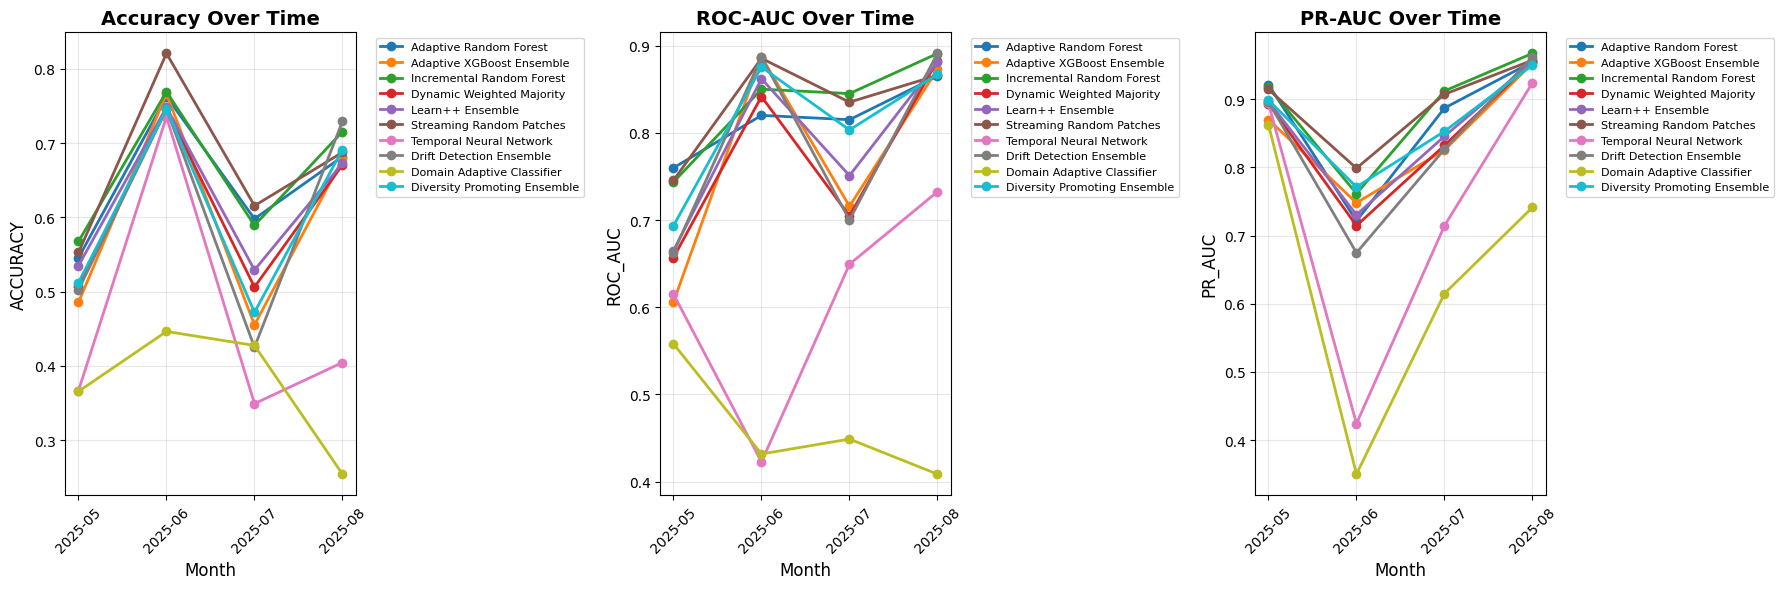


📊 Plot saved as 'concept_drift_comparison.png'

📈 SUMMARY: AVERAGE PERFORMANCE ACROSS ALL TEST MONTHS

                              accuracy   roc_auc    pr_auc
model                                                     
Streaming Random Patches      0.669243  0.833185  0.894581
Incremental Random Forest     0.660411  0.832555  0.889812
Adaptive Random Forest        0.647067  0.815121  0.871389
Diversity Promoting Ensemble  0.605313  0.810009  0.868468
Learn++ Ensemble              0.621342  0.789992  0.857188
Drift Detection Ensemble      0.600721  0.785331  0.839953
Dynamic Weighted Majority     0.607434  0.771624  0.849150
Adaptive XGBoost Ensemble     0.596406  0.770565  0.849261
Temporal Neural Network       0.463945  0.604976  0.739240
Domain Adaptive Classifier    0.373443  0.461822  0.642392

🏆 BEST MODELS:
Best Accuracy: Streaming Random Patches (0.669)
Best ROC-AUC:  Streaming Random Patches (0.833)
Best PR-AUC:   Streaming Random Patches (0.895)

💾 Results saved to 'concept

In [ ]:
# ====================================================
# 🧩 MAIN EXECUTION
# ====================================================
if __name__ == "__main__":

    # Load data
    print("📂 Loading data...")
    df = pd.read_csv("youtube_tiktok_trends_2025_preprocessed.csv", low_memory=False)

    # Drop leakage columns
    leak_cols = ['trend_label_encoded','rel_combo','likes_per_day','share_rate_log','views','views_per_day','like_rate',
                 'comment_rate','share_rate','like_rate_log','comment_rate_log','rel_like','rel_share','avg_velocity_y',
                 'avg_er','richness_traffic_interaction','country_x','country_y','top_hashtag','like_rate_zscore',
                 'comment_rate_zscore','share_rate_zscore','traffic_source_feed','traffic_source_hashtag',
                 'traffic_source_profile','traffic_source_search','traffic_source_share','platform_x','platform_y',
                 'creator_tier','title_len','text_richness','traffic_source_cat','device_brand_cat','creator_tier_cat',
                 'like_hashtag_interaction','share_hashtag_interaction']

    df = df.drop(columns=[c for c in leak_cols if c in df.columns], errors='ignore')
    df = df.dropna(subset=['trend_label'])

    # Feature engineering
    print("🔧 Feature engineering...")
    df['month_num'] = pd.to_datetime(df['year_month'], format='%Y-%m', errors='coerce').dt.month
    df['quarter'] = pd.to_datetime(df['year_month'], format='%Y-%m', errors='coerce').dt.quarter
    df['platform_cat'] = df['platform_cat'].astype(str).fillna('Unknown')
    df['category_cat'] = df['category_cat'].astype(str).fillna('Unknown')
    df['platform_category'] = df['platform_cat'] + "_" + df['category_cat']
    df['region_cat'] = df['region_cat'].astype(str).fillna('Unknown')
    df['language_cat'] = df['language_cat'].astype(str).fillna('Unknown')
    df['region_language'] = df['region_cat'] + "_" + df['language_cat']

    df = df.sort_values(['category_cat', 'year_month'])
    df['n_videos_prev'] = df.groupby('category_cat')['n_videos'].shift(1)
    df['video_growth'] = (df['n_videos'] - df['n_videos_prev']) / (df['n_videos_prev'] + 1e-5)
    df['video_growth'] = df['video_growth'].replace([np.inf, -np.inf], 0).fillna(0)

    # Define features
    feature_cols = [c for c in df.columns if c not in ['trend_label', 'year_month']]
    feature_cols = list(dict.fromkeys(feature_cols))  # Remove duplicates

    print(f"✅ Total features: {len(feature_cols)}")

    # Initialize evaluator
    evaluator = ConceptDriftEvaluator()

    # Prepare monthly data
    monthly_data = evaluator.prepare_monthly_data(df, date_col='year_month', label_col='trend_label')

    # Define train/test splits
    train_months = ['2025-02', '2025-03', '2025-04']
    test_months = ['2025-05', '2025-06', '2025-07', '2025-08']

    # Run evaluation
    results_df = evaluator.evaluate_all_models(
        monthly_data=monthly_data,
        train_months=train_months,
        test_months=test_months,
        feature_cols=feature_cols,
        label_col='trend_label'
    )

    # Generate plots and summary
    evaluator.plot_comparison(results_df)
    summary = evaluator.summary_table(results_df)

    # Save results
    results_df.to_csv('concept_drift_results.csv', index=False)
    print(f"\n💾 Results saved to 'concept_drift_results.csv'")

    print(f"\n✅ EVALUATION COMPLETE!")